# Trabajo práctico integrador - Visión por Computadoras II
## Carrera de Especialización en Inteligencia Artificial - Cohorte 17
### Autores:
* Piñero, Juan Cruz 
* Lloveras, Alejandro
* Méndez, Diego Martín

**Objetivo del trabajo**

Utilizar modelos de *Computer Vision* para clasificar enfermedades de plantas (38 clases).

In [42]:
# Importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset

El dataset es 'PlantVillage' , obtenido de Kaggle con más de 50 mil imágenes RGB de hojas de cultivos sanas y enfermas, categorizadas en 38 clases diferentes. La primera versión del dataset fue disponibilizada por David. P. Hughes, Marcel Salathe y utilizado para desarrollar el proyecto 'PlantVillage' de la universidad de Penn State. https://arxiv.org/abs/1511.08060

## Contenido del dataset 

Dentro del dataset encontramos una jerarquía de carpetas que contienen imagenes. 
En el primer nivel encontramos tres carpetas que describen el tipo de imagen segun su preprocesamiento. Estas son:

- color: imagenes en color
- grayscale: mismas imagenes pero en escala de grises. En principio es desconocido el algoritmo utilizado.
    - apriori podriamos decir que la escala de grises no es ideal para detectar anomalías en cultivos, ya que muchas enfermedades se manifiestan con una diferencia de color entre las partes afectadas y las partes no afectadas.   
- segmented: mismas imagenes pero despues de aplicar algún algoritmo de segmentación. En principio es desconocido el algoritmo utilizado.
    - Haciendo una inspección inicial podemos ver que no todas las segmentaciones son de buena calidad, por lo que apriori optaríamos por usar las imágenes en color, haciendo algun preprocesamiento de las mismas por nuestra cuenta si fuera necesario.


Dentro de cada una de las tres carpetas que describen el preoposesamiento (color,grayscale,segmented) encontramos 38 carpetas, cada una con sus respectivas imagenes. Los nombres de las carpetas indican tanto la especie como la enfermedad o bien la palabra 'healthy' como indicador de que la imagen es de una planta sana . Por ejemplo, la carpeta "Apple___Apple_scab" contiene imagenes de hojas de manzana con 'Sarna del manzano'.

Como se puede ver en la descripción disponible en kaggle, el número de imagenes dentro de cada clase varía entre 152 y 5507 segun la especie y la enfermedad.

En el análisis exploratorio obtenemos una tabla resumen con las especies y las enfermedades presentes en el dataset, así como la cardinalidad de cada conjunto.



### Tamaño de las imagenes
Las imágenes se encuentran normalizadas a un tamaño de 256x256 pixeles.

 ## Descripción del problema. 

El objetivo es construir un modelo que permita diagnosticar las enfermedades mediante una foto de una hoja de una planta. Por lo tanto podemos diagramarlo como un problema de clasificación. Donde las clases son las enfermedades, en conjunto con la especie de la planta. En otras palabras , las clases podrían ser los nombres de las carpetas que contienen las imagenes.

### Estado del arte

La aplicación de deep learning en este problema ha permitido grandes avances en los resultados obtenidos . Con los modelos del estado del arte se alcanzan resultados de mas de 95% de accuracy en clasificación y niveles de precisión de más del 90% en problemas de detección y segmentación de plagas y enfermedades en plantas / cultivos.

### Modelo a implementar como solución

La cantidad de imágenes en cada directorio nos permite predecir que , al intentar resolver la clasificación, tendremos un problema de desbalance de clases. Por lo tanto será importante tomar esto en cuenta a la hora de elegir la métrica a utilizar en el entrenamiento del modelo.

La exactitud del modelo así planteado estará lógicamente limitada a las especies y enfermedades tratadas. Se podría tambien plantear un modelo donde se intente clasificar entre 'enferma' o 'sana' para intentar generalizar a otras especies o enfermedades, aunque esa generalización sería también muy limitada dada la diversidad de especies que existen en el mundo real. Dicho problema en principio no lo contemplaremos en este trabajo. Sólo nos vamos a limitar a clasificar entre las 38 clases presentes en el dataset.

Una forma de incorporar al modelo más complejidad e intentar abarcar otras especies podría ser utilizando Transfer Learning con un modelo pre-entrenado. Fine-tuneandolo para éste dataset. O bien utilizando técnicas / arquitecturas de Few Shot Learning. 

### Etapa de preprocesamiento

El hecho de que el dataset ya cuente con directorios donde se facilitan los datos preprocesados, nos da un indicio de que esa etapa es muy importante para el problema que se quiere resolver.

Será necesaria una etapa de preprocesamiento donde podamos aplicar algúna transformación de las imagenes para mejorar su calidad y poder obtener un mejor resultado en el entrenamiento. Dichas transformaciones podrían consistir tanto en el resize como en transformaciones de espacio de color, segmentaciones, etc. 
A modo de referencia podemos mencionar un artículo que explora el estado del arte en el tema de detección de enfermedades en plantas con Computer Vision:
[(Trends in Machine and Deep Learning Techniques for Plant Disease Identification: A Systematic Review)]: 
https://www.researchgate.net/profile/Juvenal-Rodriguez/publication/386275339_Trends_in_Machine_and_Deep_Learning_Techniques_for_Plant_Disease_Identification_A_Systematic_Review/links/674b1535f309a268c0193cd3/Trends-in-Machine-and-Deep-Learning-Techniques-for-Plant-Disease-Identification-A-Systematic-Review.pdf

Según este artículo se destacan los siguientes items clave en el preprocesamiento de las imagenes:
- Resizing y cropping. La arquitectura a utilizar puede llegar a requerir un tamaño determinado de la imagen de entrada.
- Normalización de las imagenes. Podria ser necesario llevar los valores de los pixeles a un rango normalizado [0,1]. Esto suele mitigar los efectos de variaciones en brillo y contraste.
- Reducción de ruido.
- Data augmentation: este proceso es clave cuando se cuenta con datasets de tamaño o dispoinibilidad limitada. Se pueden aplicar operaciones variadas a las imagenes para aumentar la cantidad de datos y mejorar la generalizabilidad del modelo. Incluso se podría aplicar una GAN para generar imagenes sinteticas.
- Transformaciones de espacio de color: podria ser a escala de grises, HSV, etc.



**Link:** https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset

In [43]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/juan/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3


## Importación de imágenes

In [44]:
import os
import logging

In [45]:
# CONFIGURACIÓN INICIAL:

# Ruta de acceso al dataset
ROOT_DIR = path+'/plantvillage dataset/color'

# Separador usado en los nombres de las subcarpetas
SEPARATOR = '___' # Separa entre 'group' y 'class'

# Extensiones de archivo de imagen a considerar (en minúsculas)
IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp'}

# Configuración básica de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [46]:
def process_image_directory(root_dir, separator='___', valid_extensions=None):
    """
    Recorre un directorio raíz, extrae rutas de imágenes y metadatos de subcarpetas.

    Args:
        root_dir (str): La ruta al directorio raíz que contiene las subcarpetas de clases.
        separator (str): El separador utilizado en los nombres de las subcarpetas
                         para dividir 'group' y 'class'.
        valid_extensions (set, optional): Un conjunto de extensiones de archivo (en minúsculas,
                                          incluyendo el punto) a considerar como imágenes.
                                          Si es None, se usará un conjunto predeterminado.

    Returns:
        pandas.DataFrame: Un DataFrame con las columnas 'image_path', 'filename', 'group', 'class'.
                          Retorna un DataFrame vacío si el directorio raíz no existe o
                          no se encuentran imágenes válidas.
    """
    if valid_extensions is None:
        valid_extensions = IMAGE_EXTENSIONS # Verifica que sean archivos de imagen

    data = []
    output_columns = ['image_path', 'filename', 'group', 'class'] # Define la estructura para el Dataframe

    if not os.path.isdir(root_dir):
        logging.error(f"El directorio raíz especificado no existe: {root_dir}")
        return pd.DataFrame(data, columns=output_columns) # Asegura que exista el directorio

    logging.info(f"Comenzando el procesamiento del directorio: {root_dir}")

    # Exploración de cada sucarpeta
    for entry in os.scandir(root_dir):
        if entry.is_dir():
            subdir_name = entry.name
            subdir_path = entry.path
            logging.info(f"Procesando subdirectorio: {subdir_name}")

            if separator in subdir_name:
                try:
                    group_name, class_name = subdir_name.split(separator, 1)
                except ValueError:
                    logging.warning(f"No se pudo dividir el nombre '{subdir_name}' usando '{separator}'. Saltando directorio.")
                    continue

                for sub_entry in os.scandir(subdir_path):
                    if sub_entry.is_file():
                        file_name = sub_entry.name
                        file_path = sub_entry.path

                        _, extension = os.path.splitext(file_name)
                        if extension.lower() in valid_extensions:
                            relative_path = os.path.relpath(os.path.dirname(file_path), root_dir) # Carpeta dónde encontrar a imagen
                            
                            # Almacena toda la información
                            data.append({
                                'image_path': f"{relative_path}/",
                                'filename': file_name,
                                'group': group_name,
                                'class': class_name
                            })
                        else:
                            logging.debug(f"Archivo omitido (no es imagen válida): {file_path}")
            else:
                logging.warning(f"El nombre del subdirectorio '{subdir_name}' no contiene el separador '{separator}'. Saltando.")

    if not data:
        logging.warning("No se encontraron imágenes válidas en la estructura de directorios especificada.")

    # Construye el DataFrame
    df = pd.DataFrame(data, columns=output_columns)
    logging.info(f"Proceso completado. Se encontraron {len(df)} imágenes.")
    return df

In [47]:
df = process_image_directory(ROOT_DIR)

2025-04-04 20:16:41,608 - INFO - Comenzando el procesamiento del directorio: /home/juan/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/color
2025-04-04 20:16:41,609 - INFO - Procesando subdirectorio: Potato___healthy
2025-04-04 20:16:41,610 - INFO - Procesando subdirectorio: Apple___Apple_scab
2025-04-04 20:16:41,614 - INFO - Procesando subdirectorio: Apple___Cedar_apple_rust
2025-04-04 20:16:41,616 - INFO - Procesando subdirectorio: Orange___Haunglongbing_(Citrus_greening)
2025-04-04 20:16:41,641 - INFO - Procesando subdirectorio: Squash___Powdery_mildew
2025-04-04 20:16:41,648 - INFO - Procesando subdirectorio: Peach___healthy
2025-04-04 20:16:41,650 - INFO - Procesando subdirectorio: Cherry_(including_sour)___Powdery_mildew
2025-04-04 20:16:41,655 - INFO - Procesando subdirectorio: Tomato___Tomato_mosaic_virus
2025-04-04 20:16:41,656 - INFO - Procesando subdirectorio: Blueberry___healthy
2025-04-04 20:16:41,663 - INFO - Procesando subdi

In [48]:
df.sample(5)

,image_path,filename,group,class
12690,Grape___Leaf_blight_(Isariopsis_Leaf_Spot)/,69a14243-b896-4910-8c9a-f96920d738d8___FAM_L.B...,Grape,Leaf_blight_(Isariopsis_Leaf_Spot)
14596,Tomato___healthy/,6949b108-03f0-4cee-b91a-bb5b23e93249___GH_HL L...,Tomato,healthy
27630,Peach___Bacterial_spot/,edb67083-c1e5-410b-a05e-182bd333e1ce___Rutg._B...,Peach,Bacterial_spot
7202,Squash___Powdery_mildew/,9750b896-780b-4c18-a484-6b6acb720425___UMD_Pow...,Squash,Powdery_mildew
15244,Corn_(maize)___Common_rust_/,RS_Rust 2122.JPG,Corn_(maize),Common_rust_


In [49]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54305 entries, 0 to 54304
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  54305 non-null  object
 1   filename    54305 non-null  object
 2   group       54305 non-null  object
 3   class       54305 non-null  object
dtypes: object(4)
memory usage: 1.7+ MB


In [50]:
df.describe()

,image_path,filename,group,class
count,54305,54305,54305,54305
unique,38,54305,14,21
top,Orange___Haunglongbing_(Citrus_greening)/,7c479d6b-0f9a-4646-8337-445b76d2959e___RS_GLSp...,Tomato,healthy
freq,5507,1,18160,15084


In [51]:
print("Conteo por grupo:")
print(df['group'].value_counts())

Conteo por grupo:
group
Tomato                     18160
Orange                      5507
Soybean                     5090
Grape                       4062
Corn_(maize)                3852
Apple                       3171
Peach                       2657
Pepper,_bell                2475
Potato                      2152
Cherry_(including_sour)     1906
Squash                      1835
Strawberry                  1565
Blueberry                   1502
Raspberry                    371
Name: count, dtype: int64


In [52]:
print("Conteo por clase:")
print(df['class'].value_counts())

Conteo por clase:
class
healthy                                 15084
Haunglongbing_(Citrus_greening)          5507
Bacterial_spot                           5421
Tomato_Yellow_Leaf_Curl_Virus            5357
Late_blight                              2909
Powdery_mildew                           2887
Early_blight                             2000
Black_rot                                1801
Septoria_leaf_spot                       1771
Spider_mites Two-spotted_spider_mite     1676
Target_Spot                              1404
Esca_(Black_Measles)                     1383
Common_rust_                             1192
Leaf_scorch                              1109
Leaf_blight_(Isariopsis_Leaf_Spot)       1076
Northern_Leaf_Blight                      985
Leaf_Mold                                 952
Apple_scab                                630
Cercospora_leaf_spot Gray_leaf_spot       513
Tomato_mosaic_virus                       373
Cedar_apple_rust                          275
Name: coun

## Carga de imágenes

In [53]:
from PIL import Image
import os
def load_image(data: pd.DataFrame, index: int, root: str=ROOT_DIR):
    """
    Carga una imagen PIL desde una fila específica de un DataFrame.

    Args:
        dataframe (pandas.DataFrame): El DataFrame que contiene las rutas de las imágenes.
        index (int): El índice de la fila en el DataFrame para cargar la imagen.
        root_dir (str): El directorio raíz donde se encuentran las imágenes.

    Returns:
        PIL.Image.Image: La imagen cargada como un objeto PIL.Image, o None si ocurre un error.
    """
    if index < 0 or index >= len(data):
        print("Índice fuera de rango.")
        return None

    row = data.iloc[index]
    relative_path = row['image_path']
    filename = row['filename']
    full_path = os.path.join(root, relative_path, filename)

    try:
        img = Image.open(full_path)
        return img
    except FileNotFoundError:
        print(f"Archivo no encontrado: {full_path}")
        return None
    except Exception as e:
        print(f"Error al cargar la imagen: {e}")
        return None

In [54]:
df

,image_path,filename,group,class
0,Potato___healthy/,923d4cc3-021a-4bcd-9f5f-1d6f69e4ad33___RS_HL 1...,Potato,healthy
1,Potato___healthy/,80bb8697-bfab-449b-b870-e1ed2089df58___RS_HL 1...,Potato,healthy
2,Potato___healthy/,1ae826e2-5148-47bd-a44c-711ec9cc9c75___RS_HL 1...,Potato,healthy
3,Potato___healthy/,ec6e43d3-512d-4908-99f2-c9e2a0be54be___RS_HL 4...,Potato,healthy
4,Potato___healthy/,369479a9-3c28-4d77-8731-9ae54e719af3___RS_HL 1...,Potato,healthy
...,...,...,...,...
54300,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,910679a5-f18d-40ac-a00e-9e2c27a45610___RS_GLSp...,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot
54301,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,57e4abec-e203-4574-85f8-bc321b0e0ac3___RS_GLSp...,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot
54302,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,14913b5b-f425-43f4-8266-e6c353f96781___RS_GLSp...,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot
54303,Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...,2b6bb6a5-3f70-48da-a968-13d840815bbb___RS_GLSp...,Corn_(maize),Cercospora_leaf_spot Gray_leaf_spot


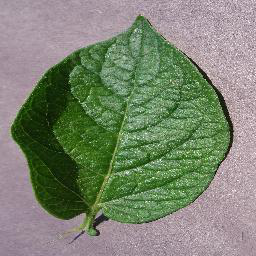

In [55]:
# Permite visualizar una imagen específica (con iloc)
index = 0 # Indice de la imagen a cargar
image = load_image(data=df, index=index, root=ROOT_DIR)

#image.show() #popup option
image

## Tamaño de las imágenes

In [59]:
sizes = []
for index in range (0,df.shape[0]):
    
    image = load_image(data=df, index=index, root=ROOT_DIR)
    sizes.append(image.size)

In [61]:
set(sizes)

{(256, 256)}

## Dataset split

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
def split_data(df,
               target_column='class',
               test_size=0.20,
               validation_size=0.0, # Por defecto no define un conjunto de validación
               random_state=42,     # Semilla para reproducibilidad
               split_column_name='split'):
    """
    Añade una columna al DataFrame indicando la división (train/test/validation).

    Realiza una división estratificada para mantener el balance de clases.

    Args:
        df (pd.DataFrame): DataFrame de entrada con al menos la columna 'target_column'.
        target_column (str): Nombre de la columna que contiene las etiquetas de clase
                             para la estratificación (ej: 'class').
        test_size (float): Proporción del dataset a incluir en el conjunto de test (ej: 0.20).
        validation_size (float): Proporción del dataset a incluir en el conjunto de validación.
                                 La proporción de entrenamiento será 1.0 - test_size - validation_size.
                                 Si es 0.0, solo se crearán conjuntos de train y test.
        random_state (int): Semilla para el generador de números aleatorios para asegurar
                            divisiones reproducibles.
        split_column_name (str): Nombre de la nueva columna que contendrá las etiquetas
                                 'train', 'test' o 'validation'.

    Returns:
        pd.DataFrame: El DataFrame original con la nueva columna 'split_column_name'.

    Raises:
        ValueError: Si test_size + validation_size >= 1.0, o si target_column no existe.
        ImportError: Si scikit-learn no está instalado.
    """
    if target_column not in df.columns:
        raise ValueError(f"La columna objetivo '{target_column}' no se encuentra en el DataFrame.")

    if not isinstance(test_size, float) or not (0.0 <= test_size < 1.0):
         raise ValueError("test_size debe ser un float entre 0.0 y 1.0.")

    if not isinstance(validation_size, float) or not (0.0 <= validation_size < 1.0):
         raise ValueError("validation_size debe ser un float entre 0.0 y 1.0.")

    if test_size + validation_size >= 1.0:
        raise ValueError("La suma de test_size y validation_size debe ser menor que 1.0.")

    # Crear la nueva columna inicializada (opcional, pero ayuda a la claridad)
    df[split_column_name] = 'unassigned'

    # Extraer etiquetas para estratificación
    labels = df[target_column]
    indices = df.index # Usaremos los índices para la división

    # --- Lógica de División ---

    # Caso 1: División en Train / Test (sin Validación)
    if validation_size == 0.0:
        train_indices, test_indices = train_test_split(
            indices,
            test_size=test_size,
            random_state=random_state,
            stratify=labels # Permite mantener el balance de clases
        )
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[test_indices, split_column_name] = 'test'
        logging.info(f"División completada: Train ({1-test_size:.1%}), Test ({test_size:.1%}). Estratificada por '{target_column}'.")

    # Caso 2: División en Train / Validation / Test
    else:
        # Paso 1: Dividir en (Train + Validation) y Test
        remaining_indices, test_indices = train_test_split(
            indices,
            test_size=test_size, # Tamaño final del conjunto de test
            random_state=random_state,
            stratify=labels
        )

        # Calcular el tamaño relativo de validación respecto al conjunto restante (Train + Validation)
        # Ejemplo: test=0.2, val=0.1 -> Total 0.3. Restante 0.7. val_rel = 0.1 / 0.7 = 0.142...
        # train_test_split tomará el 14.2% del 70% restante, lo que equivale al 10% del total original.
        relative_val_size = validation_size / (1.0 - test_size)

        # Obtener las etiquetas correspondientes SOLO al conjunto restante para la segunda estratificación
        remaining_labels = df.loc[remaining_indices, target_column]

        # Paso 2: Dividir el conjunto restante en Train y Validation
        train_indices, validation_indices = train_test_split(
            remaining_indices, # Dividir solo los índices restantes
            test_size=relative_val_size, # Tamaño relativo calculado
            random_state=random_state,   # Usar la misma semilla para consistencia
            stratify=remaining_labels    # Estratificar usando las etiquetas restantes
        )

        # Asignar etiquetas de división al DataFrame original
        df.loc[train_indices, split_column_name] = 'train'
        df.loc[validation_indices, split_column_name] = 'valid'
        df.loc[test_indices, split_column_name] = 'test'

        train_actual_prop = len(train_indices) / len(df)
        val_actual_prop = len(validation_indices) / len(df)
        test_actual_prop = len(test_indices) / len(df)
        logging.info(f"División completada: Train ({train_actual_prop:.1%}), Validation ({val_actual_prop:.1%}), Test ({test_actual_prop:.1%}). Estratificada por '{target_column}'.")

    return df

In [36]:
# Disivión del dataset
# (Ejemplo: 70% train, 15% validation, 15% test)
try:
        df_split = split_data(df.copy(), # Usar .copy() para no modificar el original directamente aquí
                                target_column='class',
                                test_size=0.2,
                                validation_size=0.1,
                                random_state=42) # Usa la semilla que prefieras

except ValueError as e:
        print(f"\nError al dividir los datos: {e}")
except ImportError:
        print("\nError: La biblioteca scikit-learn no está instalada. Por favor, instálala con 'pip install scikit-learn'")
except Exception as e:
        print(f"\nOcurrió un error inesperado: {e}")


2025-04-04 18:56:49,117 - INFO - División completada: Train (70.0%), Validation (10.0%), Test (20.0%). Estratificada por 'class'.


In [37]:
df_split.sample(5)

,image_path,filename,group,class,split
452,Apple___Apple_scab/,5d398d0d-256d-4de5-8dcd-f3b455da2b76___FREC_Sc...,Apple,Apple_scab,train
52494,Grape___Esca_(Black_Measles)/,c495c21c-1ce4-4da9-a737-56d2f30d4ab0___FAM_B.M...,Grape,Esca_(Black_Measles),test
1604,Orange___Haunglongbing_(Citrus_greening)/,42f55116-f60a-487f-bb65-94aa48951292___UF.Citr...,Orange,Haunglongbing_(Citrus_greening),train
31050,Tomato___Septoria_leaf_spot/,963549d4-2e44-4b10-8e73-9d955a80949c___Keller....,Tomato,Septoria_leaf_spot,train
24774,Soybean___healthy/,7c19f25e-5943-4f43-9e1f-ea5c3c9392d9___RS_HL 5...,Soybean,healthy,test


In [38]:
print("\n--- Conteo de muestras por 'split' ---")
print(df_split['split'].value_counts(normalize=True)) # normalize=True muestra proporciones

print("\n--- Verificación del Balance de Clases por 'split' ---")

# Comprobar si las proporciones de clases son similares en cada split
print(df_split.groupby('split')['class'].value_counts(normalize=True))


--- Conteo de muestras por 'split' ---
split
train    0.699991
test     0.200000
valid    0.100009
Name: proportion, dtype: float64

--- Verificación del Balance de Clases por 'split' ---
split  class                              
test   healthy                                0.277783
       Haunglongbing_(Citrus_greening)        0.101464
       Bacterial_spot                         0.099807
       Tomato_Yellow_Leaf_Curl_Virus          0.098610
       Late_blight                            0.053586
                                                ...   
valid  Leaf_Mold                              0.017492
       Apple_scab                             0.011600
       Cercospora_leaf_spot Gray_leaf_spot    0.009391
       Tomato_mosaic_virus                    0.006813
       Cedar_apple_rust                       0.004971
Name: proportion, Length: 63, dtype: float64
